In [1]:
from haplogone import (
    read_and_segment,
    filter_segments_by_size,
    plot_chromosome,
    read_bed,
    create_bed_with_thres,
    process_vcf_baf,
    read_vcf,
    segments_to_positions,
)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# female = read_and_segment(
#     "../../bioinf_semester_project/data/sample_1.vcf", chrom_subset='chrX')
male = read_and_segment("../../bioinf_semester_project/data/sample_2.vcf", chrom_subset="chrX", size_threshold = 0
    
)

# female_gatk = read_and_segment(
#     "../../bioinf_semester_project/data/sample_1/gatk_called.vcf", chrom_subset='chrX'
# )
# male_gatk = read_and_segment(
#     "../../bioinf_semester_project/data/sample_2/gatk_called.vcf", chrom_subset='chrX'
# )

In [3]:
# ber_chr20 = read_and_segment("../../bioinf_semester_project/vcf_dels/ber_chr20.vcf")
# el_chr2 = read_and_segment("../../bioinf_semester_project/vcf_dels/el_chr2.vcf")
# em_chr15 = read_and_segment("../../bioinf_semester_project/vcf_dels/em_chr15.vcf")
# er_chr1 = read_and_segment("../../bioinf_semester_project/vcf_dels/er_chr1.vcf")
# ok_chr1 = read_and_segment("../../bioinf_semester_project/vcf_dels/ok_chr1.vcf")

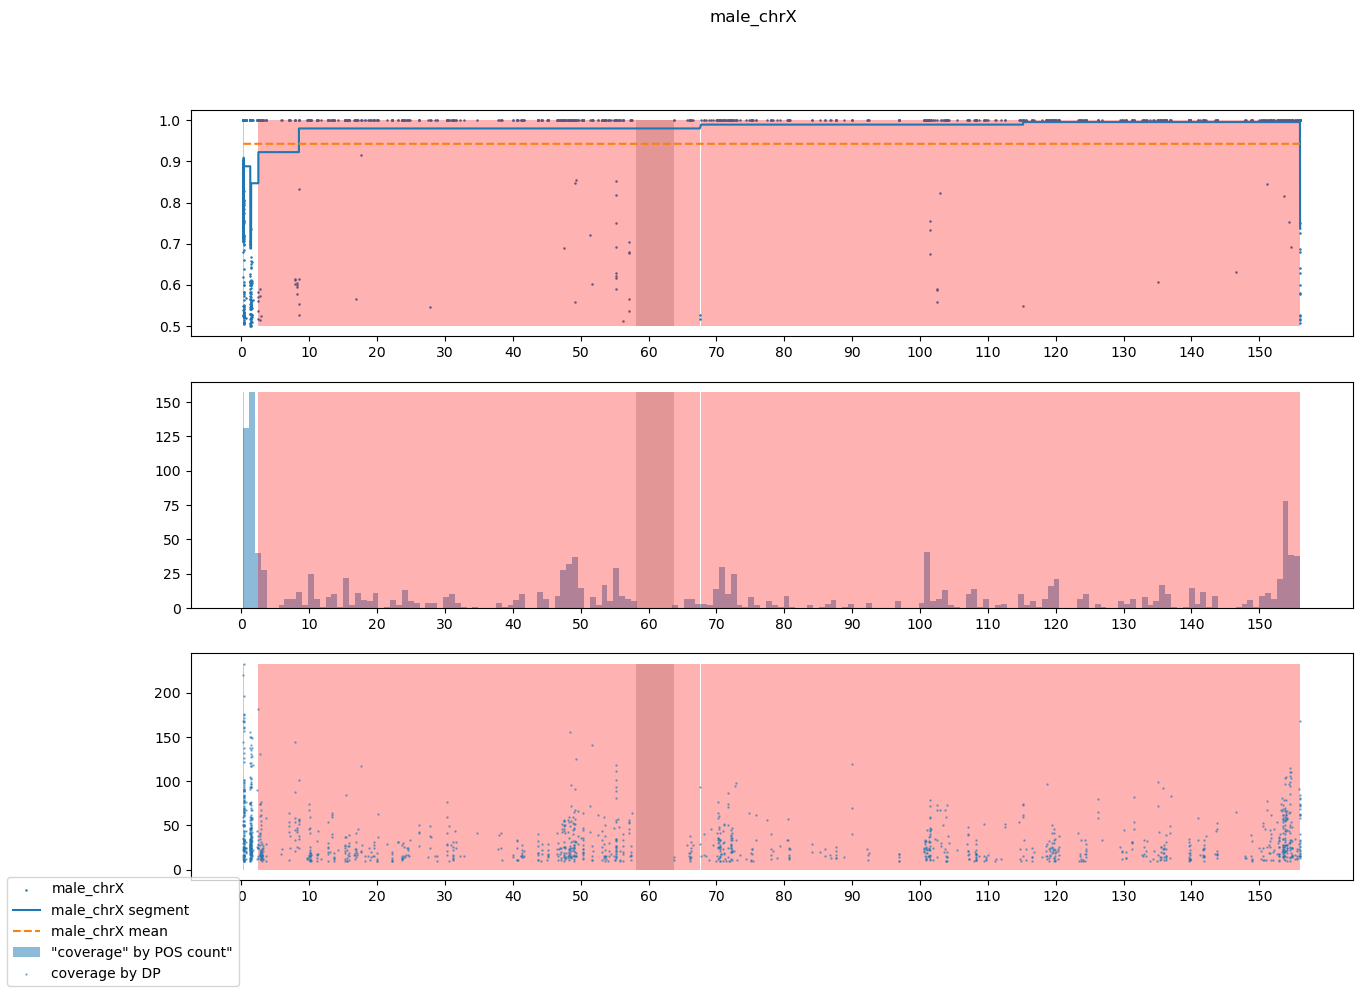

In [4]:
plot_chromosome(male, "male_chrX", "chrX", create_bed_with_thres(male, 0.9))
# plot_chromosome(female, "female_chrX", "chrX", create_bed_with_thres(female, 0.9))
# plot_chromosome(
#     male_gatk, "male_gatk_chrX", "chrX", create_bed_with_thres(male_gatk, 0.9)
# )
# plot_chromosome(
#     female_gatk, "female_gatk_chrX", "chrX", create_bed_with_thres(female_gatk, 0.9)
# )
# plot_chromosome(ber_chr20, "ber_chr20", "chr20", create_bed_with_thres(ber_chr20, 0.9))
# plot_chromosome(el_chr2, "el_chr2", "chr2", create_bed_with_thres(el_chr2, 0.9))
# plot_chromosome(em_chr15, "em_chr15", "chr15", create_bed_with_thres(em_chr15, 0.9))
# plot_chromosome(er_chr1, "er_chr1", "chr1", create_bed_with_thres(er_chr1, 0.9))
# plot_chromosome(ok_chr1, "ok_chr1", "chr1", create_bed_with_thres(ok_chr1, 0.9))

In [5]:
male = process_vcf_baf(
    read_vcf(
        "../../bioinf_semester_project/data/sample_2.vcf",
    ),
    ad_cutoff=10,
)

In [6]:
segments_to_positions(male, chrom_subset="chrX", size_threshold=0)

TypeError: segments_to_positions() missing 1 required positional argument: 'size_threshold'